In [1]:
from SCF import SCFprofile, SZdist, nSCFT_VFP

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from refnx.reflect import SLD, Slab, ReflectModel, MixedReflectModel
from refnx.dataset import ReflectDataset as RD
from refnx.analysis import Objective, CurveFitter, PDF, Parameter, Parameters, process_chain, load_chain, GlobalObjective
from refnx.reflect import Exponential, Linear, Spline

import sys
sys.path.append('./../../refnxtoolbox/')

import plottools

# Fitting

According to Vincent et al., $l_\text{lat}$ and $m_\text{lat}$ should be
calculated by the formulas:


$$l_\mathrm{lat} = \frac{a^2 m/l}{p_l}$$

$$m_\text{lat} = \frac{(a m/l)^2}{p_l}$$


where $l$ is the real polymer's bond length, $m$ is the real segment mass,
and $a$ is the ratio between molecular weight and radius of gyration at
theta conditions. The lattice persistence, $p_l$, is:

$$p_l = \frac16 \frac{1+1/Z}{1-1/Z}$$

with coordination number $Z = 6$ for a cubic lattice, $p_l = .233$.

for PNIPAM, $m=114\ \rm{Da}$  and  $l\approx2.5\ \rm{Å}$ (assuming a C-C bond length is $1.53\ \rm{Å}$ and the bond angle is $111.7\ ˚$)

I don't know what $a$ is though. attempts to calculated it from literature confuse me. 

As this is just an example, I'm using a persistance length of 10 repeat units for PNIPAM. Very approximate calcs yeild:

$$l_\text{lat} = 15\ \rm{Å}$$
$$m_\text{lat} = 1100\ \rm{Da}$$

Vincent, B., Edwards, J., Emmett, S., & Croot, R. (1988).
    Phase separation in dispersions of weakly-interacting particles in
    solutions of non-adsorbing polymer. Colloids and Surfaces, 31, 267–298.
    doi:10.1016/0166-6622(88)80200-2
    
    

In [2]:
data = RD('pNIPAM brush in d2o at 25C.dat')


In [3]:
Si   = SLD(2.07, 'Silicon')
SiO2 = SLD(3.47, 'Silica')
D2O  = SLD(6.3, 'D2O') 
PNIPAM = SLD(0.9, 'PNIPAM')

In [4]:
silica_layer = SiO2(15)
silica_layer.thick.setp (value=15, bounds=(10,20), vary=True)
silica_layer.vfsolv.setp(value=0.1, bounds=(0,0.15), vary=True)
silica_layer.rough.setp (value=2, bounds=(1,4), vary=True)


sPNIPAM_layer = nSCFT_VFP(  adsorbed_amount=120,
                            lattice_size=15,
                            polymerMW=200000,
                            latticeMW=1100,
                            pdi=1.3,
                            polymer_sld=PNIPAM,
                            chi=0,
                            chi_s=2.2,
                            name='PDMS VFP',
                          )
    
sPNIPAM_layer.adsorbed_amount.setp(90,150)
sPNIPAM_layer.pdi.setp(bounds=(1.01,1.5), vary=True)
sPNIPAM_layer.chi.setp(bounds=(-0.2,0.8), vary=True)
sPNIPAM_layer.chi_s.setp(bounds=(0.5,3), vary=True)
sPNIPAM_layer.polymerMW.setp(bounds=(30000,500000), vary=True)


D2O_layer = D2O(0)

D2O_structure_PDMS  = Si | silica_layer | sPNIPAM_layer | D2O_layer
D2O_structure_PDMS.name = 'D2O'


D2Omodel = ReflectModel(D2O_structure_PDMS)
D2Omodel.bkg.setp(value=1e-6, bounds=(5e-7, 1e-5), vary=True)

D2Oobj = Objective(D2Omodel, data, name='D$_2$O')

no dist model provided, using schulz-zimm distribution


/Users/isaac/Documents/GitHub/refnx-models/polymer_brushes/SCF.py:816: RuntimeWarning: overflow encountered in multiply
  g_zs[:, r] = pg_zs = old_correlate(pg_zs, coeff, 1) * g_z
/Users/isaac/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


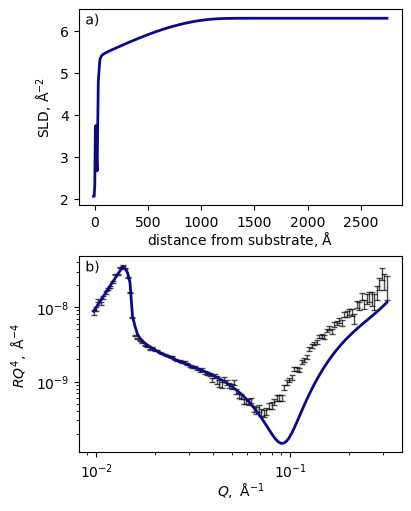

In [5]:
fig, [__, ax1, ax2] = plottools.graph_plot(objective=D2Oobj, color=plt.cm.plasma, offset=1e-1,  ystyle='rq4', xstyle='log', vf_plot=False)

In [6]:
fitter = CurveFitter(D2Oobj)
fitter.fit('least_squares');

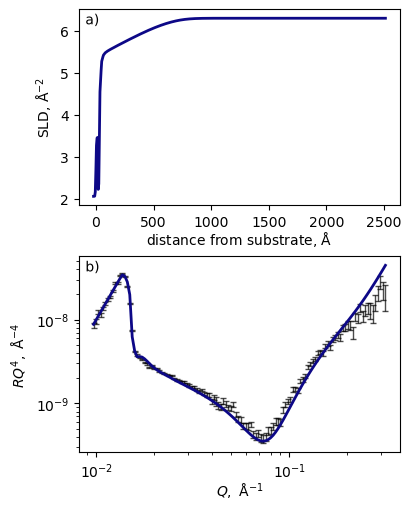

In [7]:
fig, [__, ax1, ax2] = plottools.graph_plot(objective=D2Oobj, color=plt.cm.plasma, offset=1e-1,  ystyle='rq4', xstyle='log', vf_plot=False)

In [8]:
for x in D2Oobj.varying_parameters():
    print (x)

<Parameter:     'bkg'     , value=4.43631e-06 +/- 2.73e-07, bounds=[5e-07, 1e-05]>
<Parameter:'Silica - thick', value=19.3919 +/- 3.81 , bounds=[10.0, 20.0]>
<Parameter:'Silica - rough', value=4  +/- 5.3 , bounds=[1.0, 4.0]>
<Parameter:'Silica - volfrac solvent', value=1.90943e-08 +/- 0.149, bounds=[0.0, 0.15]>
<Parameter:'PDMS VFP - adsorbed amount', value=70.5814 +/- 1.27 , bounds=[-inf, inf]>
<Parameter:'PDMS VFP - chi', value=0.146751 +/- 0.08 , bounds=[-0.2, 0.8]>
<Parameter:'PDMS VFP - chi substrate', value=2.96736 +/- 1.59 , bounds=[0.5, 3.0]>
<Parameter:'PDMS VFP - polymer MW', value=182498 +/- 2.26e+04, bounds=[30000.0, 500000.0]>
<Parameter:'PDMS VFP - polydispersity index', value=1.20442 +/- 0.0281, bounds=[1.01, 1.5]>
